In [1211]:
# Importing required libraries
import numpy as np
from numpy import pi,sin,cos,arccos
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.optimize import fsolve

In [1212]:
# Given design specifications

OD_o = 8.5  # Outer tube #mm
ID_o = 7.0 
OR_o = OD_o/2 # outer radius for outer tube
IR_o = ID_o/2

OD_i = 5.5   # Inner tube, outer diameter
ID_i = 4 
OR_i = OD_i/2 # outer radius for inner tube
IR_i = ID_i/2
# print(OR_i,OR_o)

n = 15  # Number of notches

L_curve = (c+h)*n # Length of curve in mm

c = 5 #mm (outer) (for both inner and outer tube)
h = 5 # mm
g_o = 7.5
g_i = 4.5

phi_o = [pi if i < 5 else 0 for i in range(n)]
phi_i = [0 if i < 5 else pi for i in range(n)]

## Neutral Axis Offset

In [1213]:
# Given: depth g, inner radius r_i, outer radius r_o
# Find: neutral bending plane, y
def calculate_ybar(g, r_i, r_o):
    from math import sin, acos, pi

    # Ensure the arguments for acos are within the valid range [-1, 1]
    arg_o = (g - r_o) / r_o
    arg_i = (g - r_o) / r_i
    # print("Arg_i:",arg_i, "Arg_o:",arg_o)
    if not (-1 <= arg_o <= 1 and -1 <= arg_i <= 1):
        return "Error: Input results out of domain for acos function."
    

    # Calculate phi_o and phi_i (phi here refering to CPPR paper 1)
    phi_o = 2 * arccos(arg_o)
    phi_i = 2 * arccos(arg_i)
    # print(phi_i, phi_o)

    # Calculate areas A_o and A_i
    A_o = (r_o**2 * (phi_o - sin(phi_o))) / 2
    A_i = (r_i**2 * (phi_i - sin(phi_i))) / 2
    # print(A_i, A_o)

    # Calculate centroids y_o and y_i
    y_o = (4 * r_o * sin(0.5 * phi_o)**3) / (3 * (phi_o - sin(phi_o)))
    y_i = (4 * r_i * sin(0.5 * phi_i)**3) / (3 * (phi_i - sin(phi_i)))

    # Calculate neutral bending plane y_bar
    y= (y_o * A_o - y_i * A_i) / (A_o - A_i)
    y_bar = abs(y)

    return y_bar

In [1214]:
# find y for inner tube and outer tube
y_i_bar = calculate_ybar(g_i, IR_i, OR_i)
y_o_bar = calculate_ybar(g_o, IR_o, OR_o)
print("y_i_bar:",y_i_bar,"y_o_bar:", y_o_bar)
y_i = y_i_bar*cos(phi_i)
y_o = y_o_bar*cos(phi_o)
print("y_i:",y_i,"y_o:", y_o)

y_i_bar: 2.195168262694937 y_o_bar: 3.694383372192906
y_i: [ 2.19516826  2.19516826  2.19516826  2.19516826  2.19516826 -2.19516826
 -2.19516826 -2.19516826 -2.19516826 -2.19516826 -2.19516826 -2.19516826
 -2.19516826 -2.19516826 -2.19516826] y_o: [-3.69438337 -3.69438337 -3.69438337 -3.69438337 -3.69438337  3.69438337
  3.69438337  3.69438337  3.69438337  3.69438337  3.69438337  3.69438337
  3.69438337  3.69438337  3.69438337]


## Segment Curvatures

In [1215]:
# # assume constant tau
# # q and kappa correlation
# d = y_i_bar + y_o_bar 
# q_total = 10 # TABLE II (paper2)
# q = q_total / n

# # segment outer curvature, k_o_j
# def calculate_k_o(q,d,h):
#     k_o_j = q / (d * h) # [1/mm]
#     return k_o_j

In [1216]:
# # constant curvature in opposite direction
# k_o_j = calculate_k_o(q,d,h)
# # give it a sign
# k_o = k_o_j*cos(phi_o)

# k = k_o_j / (1+(y_o *k_o_j))
# k = k_o / (1+(y_o *k_o))
# print(k)

# # center line length, lj
# l = h / (1-(y_o *k))
# q_test = np.sum(l)
# print(q_test+c*n)
# print(l) 

In [1217]:
# # # curvature bending transformation
# curvature_coord = []
# x_test = []
# z_test = []
# prev_coord = [0,0,0,1] # homogenous coordinate [x,y,z,1]
# curvature_coord.append(prev_coord)
# Tr = np.array([[1, 0, 0, 0],
#                 [0, 1, 0, 0],
#                 [0, 0, 1, c],
#                 [0, 0, 0, 1]])

# for j in range(n):
#     th = k[j] * l[j] # curvature * arc length = theta
#     print(th)
#     Tb_j = np.array([[cos(th), 0, sin(th), (1-cos(th)) / k[j]],
#                     [0, 1, 0, 0],
#                     [-sin(th), 0, cos(th), sin(th) / k[j]],
#                     [0, 0, 0, 1]])

#     # transform
#     cur_coord = Tb_j @ Tr @ prev_coord
#     curvature_coord.append(cur_coord)
#     prev_coord = cur_coord

#     # x and z values
#     # print(cur_coord)
#     cur_x = cur_coord[0]
#     cur_z = cur_coord[2]

#     x_test.append(cur_x)
#     z_test.append(cur_z)
   

# # print(x_test)
# # print(z_test)

In [1218]:
# assume constant tau
# q and kappa correlation
d = y_i_bar + y_o_bar 
q_total = -15 # TABLE II (paper2)
q = q_total / n

# segment outer curvature, k_o_j
def calculate_k_o(q,d,h):
    k_o_j = q / (d * h) # [1/mm]
    return k_o_j# constant curvature in opposite direction
k_o_j = calculate_k_o(q,d,h)
curvatures_o = k_o_j * cos(phi_o)
print(curvatures_o)
# curvatures_o = []
# for i in range(q_total):
#     k_o_j = calculate_k_o(q,d,h)
#     curvatures_o.append(k_o_j * cos(phi_o))

[ 0.03395844  0.03395844  0.03395844  0.03395844  0.03395844 -0.03395844
 -0.03395844 -0.03395844 -0.03395844 -0.03395844 -0.03395844 -0.03395844
 -0.03395844 -0.03395844 -0.03395844]


In [1219]:
# d = y_i_bar + y_o_bar 
# def update(val):
#     q_total = q_slider.val
#     q = q_total / n 
#     curvatures_o = calculate_k_o(q,d,h) * cos(phi_o)
#     x, z = calculate_curve_coordinates(L_curve,n, c, h, curvatures_o)
#     return x, z

In [1220]:
# def calculate_curve_coordinates(total_length, n, c, h, curvatures_o):
#     # Generate a list of s values (arc length along the curve)
#     s_values = np.linspace(0, total_length, n + 1)

#     # Compute the curvature for each s value
#     k_values = np.array([curvature(s, n, curvatures_o, c, h) for s in s_values])

#     # Integrate curvature to get the turning angles
#     angles = cumtrapz(k_values, s_values, initial=0)

#     # Integrate the angles to get the coordinates of the curve
#     x = cumtrapz(np.sin(angles), s_values, initial=0)
#     z = cumtrapz(np.cos(angles), s_values, initial=0)

#     return x, z

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150.]


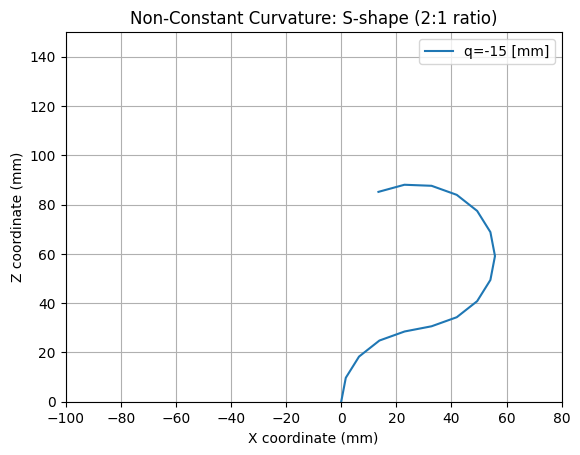

In [1221]:

# Define the curvature function
def curvature(s, n, shape, c, h):
    segment_length = c + h 
    segment_index = int(s // segment_length) # current segment
    segment_index = min(segment_index, n - 1) # array bounds
    # Return the corresponding curvature
    return shape[segment_index]


num_points = L_curve
# # Generate a list of s values (arc length along the curve)
s_values = np.linspace(0, L_curve, n+1)
print(s_values)


k_values = np.array([curvature(s, n, curvatures_o, c,h) for s in s_values])
angles = cumtrapz(k_values, s_values, initial=0) # turn angle

# curve coordinates
x = cumtrapz(np.sin(angles), s_values, initial=0)
z = cumtrapz(np.cos(angles), s_values, initial=0)


plt.plot(x, z, label=f"q={q_total} [mm]")
plt.xlim(-100,80)
plt.ylim(0,150)
plt.xlabel("X coordinate (mm)")
plt.ylabel("Z coordinate (mm)")
plt.title("Non-Constant Curvature: S-shape (2:1 ratio)")
# plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

# # p value slider
# from matplotlib.widgets import Slider
# q_slider_ax = plt.axes([0.15, 0.02, 0.65, 0.03])
# q_slider = Slider(q_slider_ax, 'Tube base displacement, q', -17, 17, valinit=0)
# q_slider.on_changed(update)



# # Calculate total curvature by integrating the curvature over the length of the segments
# segment_lengths = np.full(n, L_curve / n)
# total_curvature = cumtrapz(curvatures, segment_lengths, initial=0)




## 2d Visualization